# Translational mapping

In this notebook we explicitely model the link between the regulatory and structural embeddings of the U2OS cells and evaluate their generalizability.

---


## 0. Enviromental setup

We first load the required packages and define a number of helper functions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.optim import Adam
import sys
from tqdm.notebook import tqdm

sys.path.append("../../..")

from src.utils.notebooks.translation.analysis import *


seed = 1234

device = "cuda:0"

%load_ext nb_black

<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we read in the different data sets that we will use for the modelling and evaluation of the translational mappings. The first data set includes all structural embeddings from data held-out during training as well as the regulatory embeddings of the 244 genes that are part of the inferred interactome.

In [2]:
node_embs = pd.read_csv(
    "../../../data/ppi/embedding/node_embeddings_cv_1024.csv", index_col=0
)
node_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
CDCA2,-0.007952,-0.006754,0.007232,-0.069995,-0.069831,-0.024238,0.052615,-0.009000,-0.049085,0.047486,...,0.044995,0.025414,0.004966,0.034701,-0.009877,0.053920,-0.013999,0.006755,0.032679,0.017467
APPBP2,-0.029242,-0.010977,-0.034183,0.037372,0.097259,0.022888,0.016100,-0.064451,0.015347,0.010578,...,0.001558,-0.119956,-0.013232,-0.062533,-0.044114,0.019729,-0.008392,-0.019292,-0.017116,-0.029899
TK1,0.101693,0.040667,0.050027,-0.022686,0.009859,-0.039507,-0.010831,0.027117,0.035522,-0.075410,...,0.023617,0.025366,0.045782,-0.002047,-0.043920,-0.034587,0.022450,0.007396,-0.009525,-0.049395
MMP2,0.001542,0.050785,-0.018476,0.017569,0.083046,-0.005182,-0.070598,0.145476,0.067301,-0.099710,...,-0.040415,-0.063658,-0.129481,0.078931,-0.044539,-0.000834,-0.121958,-0.003958,-0.036362,-0.139285
PRKACA,-0.077606,0.084452,0.037822,0.080237,0.004499,-0.056642,0.029648,-0.013680,0.025614,0.027297,...,-0.098043,-0.050466,-0.036574,0.052315,-0.030286,0.100643,-0.111166,0.050694,-0.034482,0.065335


<IPython.core.display.Javascript object>

After having loaded the regulatory embeddings, we will now load the structural embeddings defined by the embeddings of the images held-out during the different folds of the cross-validation. Note that we do not group the data of the individual folds as the inferred models map to different latent spaces. We will also decode the numerical labels.

In [3]:
label_dict = {
    "AKT1S1": 0,
    "APC": 1,
    "ATF4": 2,
    "BAX": 3,
    "BCL2L11": 4,
    "BRAF": 5,
    "CASP8": 6,
    "CDC42": 7,
    "CDKN1A": 8,
    "CEBPA": 9,
    "CREB1": 10,
    "CSNK1E": 11,
    "CXXC4": 12,
    "DIABLO": 13,
    "E2F1": 14,
    "ELK1": 15,
    "EMPTY": 16,
    "ERG": 17,
    "FGFR3": 18,
    "FOXO1": 19,
    "GLI1": 20,
    "HRAS": 21,
    "IRAK4": 22,
    "JUN": 23,
    "KRAS": 24,
    "MAP2K3": 25,
    "MAP3K2": 26,
    "MAP3K5": 27,
    "MAP3K9": 28,
    "MAPK7": 29,
    "MOS": 30,
    "MYD88": 31,
    "PIK3R2": 32,
    "PKIA": 33,
    "PRKACA": 34,
    "PRKCE": 35,
    "RAF1": 36,
    "RELB": 37,
    "RHOA": 38,
    "SMAD3": 39,
    "SMAD4": 40,
    "SMO": 41,
    "SRC": 42,
    "SREBF1": 43,
    "TRAF2": 44,
    "TSC2": 45,
    "WWTR1": 46,
}

label_dict = {v: k for k, v in label_dict.items()}


img_embs_dict = {}
for i in range(4):
    img_embs = pd.read_hdf(
        "../../../data/experiments/image_embeddings/specificity_target_emb_cv_strat/final_1024/fold_{}/test_latents.h5".format(
            i
        )
    )
    img_embs.iloc[:, -1] = img_embs.iloc[:, -1].map(label_dict)
    img_embs_dict["fold{}".format(i)] = img_embs

<IPython.core.display.Javascript object>

In [4]:
img_node_embs_dict = {}
shared_targets = set(node_embs.index).intersection(label_dict.values())
for i in range(4):
    filtered_img_embs = img_embs_dict["fold{}".format(i)]
    filtered_img_embs = filtered_img_embs.loc[
        filtered_img_embs.labels.isin(shared_targets)
    ]
    filtered_node_embs = node_embs.loc[filtered_img_embs.labels]
    filtered_img_embs = filtered_img_embs.iloc[:, :-1]
    img_node_embs_dict["fold{}".format(i)] = filtered_img_embs, filtered_node_embs

<IPython.core.display.Javascript object>

---

## 3. Translational analyses

We will now use the different embeddings of the three different folds in order to model the link between the regulatory and structural space, by given a structural embedding predict the corresponding regulatory embedding. To this end, we will train a linear model for each held-out fold data. To assess the performance, we will evaluate the mapping in three distinct settings:
1. Split the data on a single-nuclei basis, i.e. samples of the same overexpression condition might end up in both the training, validation and test set.
2. Split the data on a OE condition level, i.e. samples of the a certain overexpression condition will be ending up in either of the training, validation and test set.
3. Leave-one-target out cross-validation

We will quickly setup the linear model as well as the corresponding optimizer used for that inference.

In [5]:
model = torch.nn.Sequential(
    #     torch.nn.Linear(1024, 1024),
    #     torch.nn.PReLU(),
    #     torch.nn.Linear(1024, 1024),
    #     torch.nn.PReLU(),
    torch.nn.Linear(1024, 1024),
)
model.to("cuda:0")
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()

<IPython.core.display.Javascript object>

For now we decide to use the structural embeddings of the first fold.

In [6]:
img_embs_fold0, node_embs_fold0 = img_node_embs_dict["fold0"]

<IPython.core.display.Javascript object>

In [7]:
nn = NearestNeighbors(n_neighbors=5, n_jobs=15).fit(np.array(node_embs))
nn_clf = CustomKNNClassifier(
    clf=nn, samples=np.array(list(node_embs.index)), ks=[1, 3, 5]
)

<IPython.core.display.Javascript object>

In [8]:
len(img_embs_fold0)

39041

<IPython.core.display.Javascript object>

---

### 4.1. Baseline prediction: Nuclei split

We start of with splitting the data into a training, validation and testing set without distinguishing between OE conditions. This will serve as a baseline of how well we can translate between the two spaces within sample.

In [10]:
data_dict = get_data_dict(
    data=img_embs_fold0,
    labels=node_embs_fold0,
    val_test_size=[0.2, 0.2],
    group_labels=None,
    batch_size=128,
    balanced=False,
    scale_x=True,
)

<IPython.core.display.Javascript object>

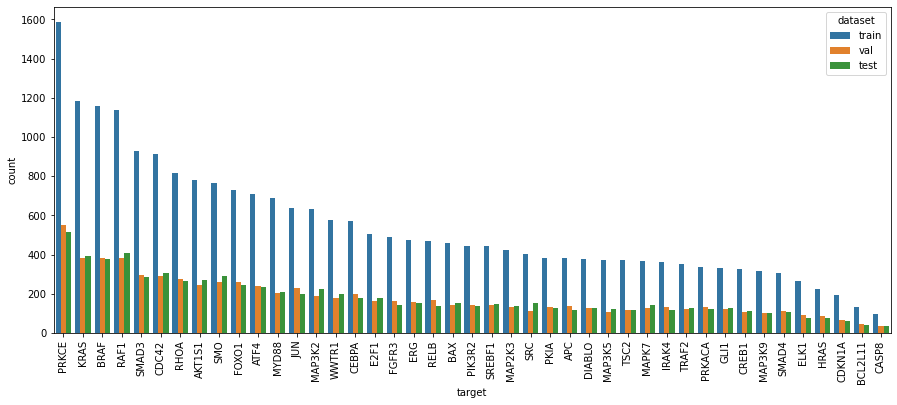

<IPython.core.display.Javascript object>

In [11]:
fig, ax, all_label_counts = plot_conditions_for_datadict(data_dict)

In [14]:
fitted_model = train_model_topk_acc(
    model=model,
    data_dict=data_dict,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=100,
    early_stopping=10,
    nn_clf=nn_clf,
    log_epochs=True,
    device=device,
)

cuda:0


  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.03579046249979995
------------------------------------------------------------
val loss: 0.010356656733717098
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0076699740828467845
------------------------------------------------------------
val loss: 0.006069310192690521
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.005110464132609752
------------------------------------------------------------
val loss: 0.00453755145006981
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.004022994246639189
------------------------------------------------------------
val loss: 0.0037771669277524363
------------------------------------------------------------
------------------------------------------------------------
train loss: 

train loss: 0.0016611758466871058
------------------------------------------------------------
val loss: 0.0017220567908046431
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0016572472946005847
------------------------------------------------------------
val loss: 0.0017403869786620384
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0016571708230932799
------------------------------------------------------------
val loss: 0.001711299797504774
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0016479035222373617
------------------------------------------------------------
val loss: 0.0016923534118982611
------------------------------------------------------------
------------------------------------------------------------
train

<IPython.core.display.Javascript object>

We see that the top-k accuracy suggest indeed a prediction that is better than naive baseline that simply predicts the k-most frequent targets for k<20 for larger k we see that the baseline outperforms the fitted model. The performances of the model on the training, validation and test set are highly comparable.

---

### 4.2. Out-of-sample prediction

In [14]:
data_dict = get_data_dict(
    data=img_embs_fold0,
    labels=node_embs_fold0,
    val_test_size=[0.2, 0.2],
    group_labels=np.array(list(node_embs_fold0.index)),
    batch_size=128,
    balanced=False,
    random_state=seed,
)

<IPython.core.display.Javascript object>

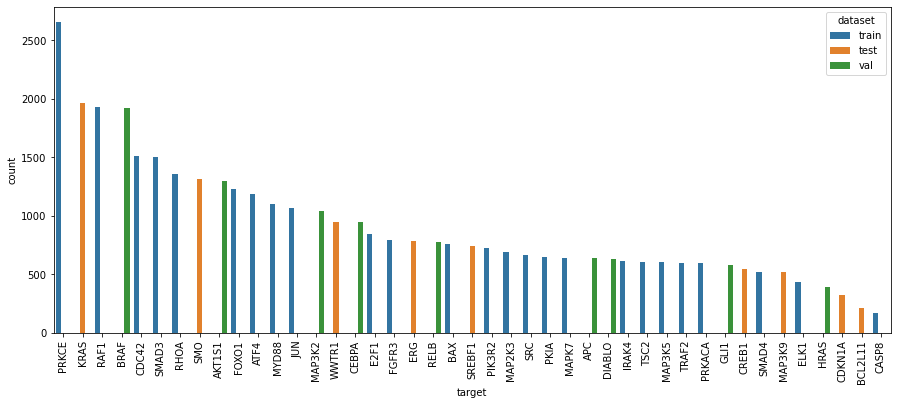

<IPython.core.display.Javascript object>

In [15]:
fig, ax, all_label_counts = plot_conditions_for_datadict(data_dict)

In [16]:
fitted_model = train_model_topk_acc(
    model=model,
    data_dict=data_dict,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=200,
    early_stopping=20,
    nn_clf=nn_clf,
    log_epochs=True,
)

train loss: 0.0017265516162362142
train top-k accuracies: {1: 0.0736, 3: 0.12643, 5: 0.1663}
------------------------------------------------------------
val loss: 0.0012435405769416982
val top-k accuracies: {1: 0.07718, 3: 0.22949, 5: 0.29379}
------------------------------------------------------------
test loss: 0.0029733870934955096
test top-k accuracies: {1: 0.05121, 3: 0.14955, 5: 0.20769}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0012357508740518906
train top-k accuracies: {1: 0.18851, 3: 0.27597, 5: 0.33609}
------------------------------------------------------------
val loss: 0.0013849350769931756
val top-k accuracies: {1: 0.06625, 3: 0.24055, 5: 0.3006}
------------------------------------------------------------
test loss: 0.0032273242600501005
test top-k accuracies: {1: 0.03029, 3: 0.0997, 5: 0.15594}
------------------------------------------------------------
-------------------

train loss: 0.0001942292634139737
train top-k accuracies: {1: 0.87506, 3: 0.93924, 5: 0.95924}
------------------------------------------------------------
val loss: 0.0014429768699023094
val top-k accuracies: {1: 0.04327, 3: 0.15133, 5: 0.2194}
------------------------------------------------------------
test loss: 0.003130597482339009
test top-k accuracies: {1: 0.01453, 3: 0.08082, 5: 0.13244}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.00018246377470887055
train top-k accuracies: {1: 0.88615, 3: 0.94708, 5: 0.96312}
------------------------------------------------------------
val loss: 0.0014864346532217213
val top-k accuracies: {1: 0.04279, 3: 0.15157, 5: 0.21101}
------------------------------------------------------------
test loss: 0.00311739197782909
test top-k accuracies: {1: 0.01807, 3: 0.08843, 5: 0.14099}
------------------------------------------------------------
------------------

<IPython.core.display.Javascript object>

Note that for the held-out configuration the baseline accuracies are not reliable as those correspond to the most frequent classes in the corresponding data set.

---

### 4.3. Leave-one-out cross-validation

Finally, we will apply leave-one-target out crossvalidation.

In [9]:
data_dicts = get_logo_data_dicts(
    data=img_embs_fold0,
    labels=node_embs_fold0,
    val_size=0.01,
    group_labels=np.array(list(node_embs_fold0.index)),
    batch_size=128,
    balanced=False,
)

<IPython.core.display.Javascript object>

In [10]:
topk_accs, mean_topk_accs = evaluate_loto_cv(
    model,
    data_dicts,
    targets=sorted(list(shared_targets)),
    optimizer=optimizer,
    criterion=criterion,
    nn_clf=nn_clf,
    device="cuda:0",
    n_epochs=40,
    early_stopping=10,
)

Run LoTo CV:   0%|          | 0/43 [00:00<?, ?it/s]

cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.001640744656743524
train top-k accuracies: {1: 0.10702, 3: 0.19093, 5: 0.24645}
train mean top-k accuracies: {1: 0.07317, 3: 0.17073, 5: 0.29268}
Target: CASP8 5NN: ['AKT1S1' 'KRAS' 'MAP3K5' 'ELK1' 'MAP3K2']
val loss: 0.0024470987495535997
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: AKT1S1 5NN: ['AKT1S1' 'KRAS' 'ELK1' 'MAP3K5' 'CDK14']
test loss: 0.0007495220497618487
test top-k accuracies: {1: 0.28164, 3: 0.74691, 5: 0.86265}
test mean top-k accuracies: {1: 1.0, 3: 1.0, 5: 1.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015931088086061117
train top-k accuracies: {1: 0.13028, 3: 0.22442, 5: 0.27902}
train mean top-k accuracies: {1: 0.02439, 3: 0.19512, 5: 0.21951}
Target: CDKN1A 5NN: ['AKT1S1' 'ELK1' 'HSPA1B' 'KRAS' 'MAP3K5']
val loss: 0.006646534341766879
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: APC 5NN: ['AKT1S1' 'KRAS' 'ELK1' 'MAP3K5' 'CDK14']
test loss: 0.0014833716287831753
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.00157}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.001616085235478023
train top-k accuracies: {1: 0.13294, 3: 0.21824, 5: 0.27136}
train mean top-k accuracies: {1: 0.09756, 3: 0.12195, 5: 0.21951}
Target: ELK1 5NN: ['AKT1S1' 'ELK1' 'MAP3K5' 'KRAS' 'MAP3K2']
val loss: 0.0008132854089771788
val top-k accuracies: {1: 0.05991, 3: 0.33871, 5: 0.62442}
val mean top-k accuracies: {1: 0.0, 3: 1.0, 5: 1.0}
Target: ATF4 5NN: ['TSC2' 'MAP3K5' 'AKT1S1' 'NCOR2' 'ELK1']
test loss: 0.001903297827197907
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.00084}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016229446376639551
train top-k accuracies: {1: 0.13229, 3: 0.22508, 5: 0.28109}
train mean top-k accuracies: {1: 0.07317, 3: 0.14634, 5: 0.21951}
Target: ELK1 5NN: ['AKT1S1' 'ELK1' 'KRAS' 'MAP3K5' 'CDK14']
val loss: 0.0008185394424816361
val top-k accuracies: {1: 0.08756, 3: 0.32028, 5: 0.55069}
val mean top-k accuracies: {1: 0.0, 3: 1.0, 5: 1.0}
Target: BAX 5NN: ['TSC2' 'AKT1S1' 'MAP3K5' 'ELK1' 'NCOR2']
test loss: 0.0021247955648557807
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016113973942634646
train top-k accuracies: {1: 0.12828, 3: 0.22309, 5: 0.28252}
train mean top-k accuracies: {1: 0.09756, 3: 0.21951, 5: 0.29268}
Target: PIK3R2 5NN: ['AKT1S1' 'ELK1' 'KRAS' 'MAP3K5' 'CDK14']
val loss: 0.0013764531571042451
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.00137}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: BCL2L11 5NN: ['MAP3K5' 'AKT1S1' 'ELK1' 'MAP3K2' 'KRAS']
test loss: 0.0030260740097092335
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0014402425931291383
train top-k accuracies: {1: 0.13111, 3: 0.23082, 5: 0.29227}
train mean top-k accuracies: {1: 0.07317, 3: 0.21951, 5: 0.29268}
Target: SMO 5NN: ['MAP3K5' 'AKT1S1' 'ELK1' 'MAP3K2' 'TSC2']
val loss: 0.007042238175292825
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: BRAF 5NN: ['AKT1S1' 'MAP3K5' 'KRAS' 'ELK1' 'MAP3K2']
test loss: 0.0014488037458197285
test top-k accuracies: {1: 0.0667, 3: 0.12819, 5: 0.16727}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015759961431623423
train top-k accuracies: {1: 0.13604, 3: 0.22538, 5: 0.27962}
train mean top-k accuracies: {1: 0.09756, 3: 0.17073, 5: 0.26829}
Target: MAP3K9 5NN: ['KRAS' 'AKT1S1' 'MAP3K2' 'MAP3K5' 'ELK1']
val loss: 0.0021294943184811703
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: CASP8 5NN: ['AKT1S1' 'KRAS' 'BCR' 'ELK1' 'MAP3K5']
test loss: 0.0022112076342301933
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016145656014231132
train top-k accuracies: {1: 0.13489, 3: 0.2332, 5: 0.28922}
train mean top-k accuracies: {1: 0.07317, 3: 0.17073, 5: 0.2439}
Target: BAX 5NN: ['AKT1S1' 'ELK1' 'MAP3K5' 'TSC2' 'CDK14']
val loss: 0.002100647147007699
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: CDC42 5NN: ['AKT1S1' 'ELK1' 'MAP3K2' 'MAP3K5' 'CDK14']
test loss: 0.002019727196071356
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015467231511482526
train top-k accuracies: {1: 0.13916, 3: 0.22626, 5: 0.28003}
train mean top-k accuracies: {1: 0.07317, 3: 0.14634, 5: 0.29268}
Target: SMAD3 5NN: ['AKT1S1' 'KRAS' 'ELK1' 'CDK14' 'MAP3K5']
val loss: 0.0025236987017216218
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: CDKN1A 5NN: ['AKT1S1' 'MAP3K5' 'ELK1' 'MAPK7' 'KRAS']
test loss: 0.006471960103990119
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016526382368881915
train top-k accuracies: {1: 0.11709, 3: 0.19776, 5: 0.24821}
train mean top-k accuracies: {1: 0.02439, 3: 0.14634, 5: 0.2439}
Target: KRAS 5NN: ['AKT1S1' 'ELK1' 'MAP3K5' 'KRAS' 'CDK14']
val loss: 0.0008358778315596283
val top-k accuracies: {1: 0.08316, 3: 0.32908, 5: 0.51939}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 1.0}
Target: CEBPA 5NN: ['MAP3K5' 'AKT1S1' 'NCOR2' 'ELK1' 'MAP3K2']
test loss: 0.0012197699266266562
test top-k accuracies: {1: 0.00845, 3: 0.10982, 5: 0.20275}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016032505631931023
train top-k accuracies: {1: 0.11969, 3: 0.20384, 5: 0.25842}
train mean top-k accuracies: {1: 0.07317, 3: 0.12195, 5: 0.14634}
Target: JUN 5NN: ['ELK1' 'AKT1S1' 'TSC2' 'MAGEA1' 'NCOR2']
val loss: 0.002098474287448969
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.00564}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: CREB1 5NN: ['TSC2' 'AKT1S1' 'ELK1' 'NCOR2' 'MAP3K5']
test loss: 0.0019220357484460533
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016253132124468312
train top-k accuracies: {1: 0.12753, 3: 0.21913, 5: 0.27455}
train mean top-k accuracies: {1: 0.09756, 3: 0.21951, 5: 0.2439}
Target: PIK3R2 5NN: ['AKT1S1' 'ELK1' 'MAP3K5' 'KRAS' 'MAP3K2']
val loss: 0.0015851930979912685
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: DIABLO 5NN: ['KRAS' 'AKT1S1' 'ELK1' 'BCR' 'CDK14']
test loss: 0.0012364632789771887
test top-k accuracies: {1: 0.0, 3: 0.00157, 5: 0.00786}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.00155453869470424
train top-k accuracies: {1: 0.1483, 3: 0.2458, 5: 0.30539}
train mean top-k accuracies: {1: 0.04878, 3: 0.17073, 5: 0.31707}
Target: SMAD3 5NN: ['AKT1S1' 'KRAS' 'MAP3K5' 'ELK1' 'THRA']
val loss: 0.002599136450271695
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: E2F1 5NN: ['AKT1S1' 'KRAS' 'ELK1' 'BCR' 'MAP3K5']
test loss: 0.0033042525727275418
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.001605568213668019
train top-k accuracies: {1: 0.128, 3: 0.22481, 5: 0.27997}
train mean top-k accuracies: {1: 0.09756, 3: 0.17073, 5: 0.26829}
Target: MAP3K9 5NN: ['MAP3K2' 'AKT1S1' 'KRAS' 'MAP3K5' 'ELK1']
val loss: 0.002483870671890433
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: ELK1 5NN: ['AKT1S1' 'KRAS' 'ELK1' 'MAP3K5' 'MAP3K2']
test loss: 0.0007932318295652588
test top-k accuracies: {1: 0.09677, 3: 0.35023, 5: 0.62212}
test mean top-k accuracies: {1: 0.0, 3: 1.0, 5: 1.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015940795789383348
train top-k accuracies: {1: 0.12695, 3: 0.21785, 5: 0.27241}
train mean top-k accuracies: {1: 0.04878, 3: 0.19512, 5: 0.26829}
Target: MAPK7 5NN: ['AKT1S1' 'KRAS' 'ELK1' 'MAP3K5' 'MAP3K2']
val loss: 0.0012152989455985483
val top-k accuracies: {1: 0.0, 3: 0.00156, 5: 0.01404}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: ERG 5NN: ['ELK1' 'AKT1S1' 'CDK14' 'MAGEA1' 'TSC2']
test loss: 0.003984622383345832
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015795356044255946
train top-k accuracies: {1: 0.14079, 3: 0.24136, 5: 0.29914}
train mean top-k accuracies: {1: 0.09756, 3: 0.2439, 5: 0.31707}
Target: E2F1 5NN: ['MAP3K5' 'AKT1S1' 'ELK1' 'MAP3K2' 'KRAS']
val loss: 0.0031070999281555766
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: FGFR3 5NN: ['AKT1S1' 'ELK1' 'KRAS' 'MAP3K5' 'MAP3K2']
test loss: 0.003832834921412255
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015778142194286572
train top-k accuracies: {1: 0.13316, 3: 0.22158, 5: 0.27769}
train mean top-k accuracies: {1: 0.09756, 3: 0.17073, 5: 0.21951}
Target: IRAK4 5NN: ['AKT1S1' 'ELK1' 'CDK14' 'TSC2' 'MAP3K5']
val loss: 0.004023280337325268
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: FOXO1 5NN: ['AKT1S1' 'KRAS' 'MAP3K5' 'ELK1' 'BCR']
test loss: 0.0015473899343837198
test top-k accuracies: {1: 0.0, 3: 0.00568, 5: 0.01705}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015580679506888558
train top-k accuracies: {1: 0.11453, 3: 0.20904, 5: 0.26503}
train mean top-k accuracies: {1: 0.04878, 3: 0.09756, 5: 0.19512}
Target: IRAK4 5NN: ['AKT1S1' 'ELK1' 'CDK14' 'TSC2' 'MAGEA1']
val loss: 0.003959530626452524
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: GLI1 5NN: ['AKT1S1' 'MAP3K5' 'ELK1' 'MAP3K2' 'TSC2']
test loss: 0.003424346954071177
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016274349273173985
train top-k accuracies: {1: 0.12281, 3: 0.21205, 5: 0.26919}
train mean top-k accuracies: {1: 0.07317, 3: 0.21951, 5: 0.21951}
Target: RHOA 5NN: ['TSC2' 'MAP3K5' 'AKT1S1' 'NCOR2' 'ELK1']
val loss: 0.0016491059449284828
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.01328}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: HRAS 5NN: ['ELK1' 'KRAS' 'AKT1S1' 'CDK14' 'MAGEA1']
test loss: 0.001270905048491637
test top-k accuracies: {1: 0.0, 3: 0.06616, 5: 0.12723}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015744454508125278
train top-k accuracies: {1: 0.12743, 3: 0.20883, 5: 0.26768}
train mean top-k accuracies: {1: 0.07317, 3: 0.14634, 5: 0.26829}
Target: DIABLO 5NN: ['AKT1S1' 'ELK1' 'KRAS' 'CDK14' 'MAP3K5']
val loss: 0.0011959022230251968
val top-k accuracies: {1: 0.0, 3: 0.00314, 5: 0.02987}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: IRAK4 5NN: ['AKT1S1' 'ELK1' 'MAP3K5' 'TSC2' 'MAP3K2']
test loss: 0.004174582407996666
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016350688343907975
train top-k accuracies: {1: 0.12761, 3: 0.21577, 5: 0.26865}
train mean top-k accuracies: {1: 0.04878, 3: 0.19512, 5: 0.21951}
Target: SREBF1 5NN: ['AKT1S1' 'MAP3K5' 'MAP3K2' 'ELK1' 'TSC2']
val loss: 0.0010895875817560497
val top-k accuracies: {1: 0.02165, 3: 0.08796, 5: 0.16509}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: JUN 5NN: ['ELK1' 'AKT1S1' 'CDK14' 'MAGEA1' 'KRAS']
test loss: 0.0026946490511466237
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016416413240045932
train top-k accuracies: {1: 0.12516, 3: 0.2135, 5: 0.26731}
train mean top-k accuracies: {1: 0.04878, 3: 0.19512, 5: 0.29268}
Target: BRAF 5NN: ['AKT1S1' 'KRAS' 'MAP3K5' 'ELK1' 'MAP3K2']
val loss: 0.0015157747856856224
val top-k accuracies: {1: 0.07556, 3: 0.14382, 5: 0.17353}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: KRAS 5NN: ['AKT1S1' 'ELK1' 'MAP3K5' 'KRAS' 'MAP3K2']
test loss: 0.0008322703219684107
test top-k accuracies: {1: 0.0898, 3: 0.35051, 5: 0.56786}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 1.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015945085955632967
train top-k accuracies: {1: 0.12441, 3: 0.21396, 5: 0.26774}
train mean top-k accuracies: {1: 0.07317, 3: 0.19512, 5: 0.2439}
Target: MAP3K5 5NN: ['AKT1S1' 'KRAS' 'ELK1' 'CDK14' 'MAP3K5']
val loss: 0.0008315372589932421
val top-k accuracies: {1: 0.06457, 3: 0.22185, 5: 0.40066}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 1.0}
Target: MAP2K3 5NN: ['AKT1S1' 'KRAS' 'ELK1' 'MAP3K5' 'MAP3K2']
test loss: 0.001737321626039685
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016180714037634693
train top-k accuracies: {1: 0.13833, 3: 0.22925, 5: 0.28168}
train mean top-k accuracies: {1: 0.09756, 3: 0.19512, 5: 0.29268}
Target: APC 5NN: ['AKT1S1' 'KRAS' 'ELK1' 'MAP3K5' 'CDK14']
val loss: 0.0015275259111135076
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: MAP3K2 5NN: ['KRAS' 'AKT1S1' 'ELK1' 'MAP3K5' 'CDK14']
test loss: 0.0009646191392745733
test top-k accuracies: {1: 0.0163, 3: 0.08917, 5: 0.22435}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.001589074313503308
train top-k accuracies: {1: 0.13421, 3: 0.22308, 5: 0.27692}
train mean top-k accuracies: {1: 0.12195, 3: 0.17073, 5: 0.19512}
Target: ERG 5NN: ['CEBPA' 'TSC2' 'NCOR2' 'ELK1' 'AKT1S1']
val loss: 0.0034859945563885846
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: MAP3K5 5NN: ['KRAS' 'AKT1S1' 'ELK1' 'CDK14' 'BCR']
test loss: 0.0008961145965758686
test top-k accuracies: {1: 0.05629, 3: 0.19702, 5: 0.34106}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015804934291437916
train top-k accuracies: {1: 0.13563, 3: 0.22733, 5: 0.28296}
train mean top-k accuracies: {1: 0.07317, 3: 0.19512, 5: 0.26829}
Target: SRC 5NN: ['AKT1S1' 'ELK1' 'KRAS' 'CDK14' 'MAP3K5']
val loss: 0.002316551207602471
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: MAP3K9 5NN: ['KRAS' 'AKT1S1' 'MAP3K2' 'ELK1' 'BRAF']
test loss: 0.002266513758415853
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016138680155586619
train top-k accuracies: {1: 0.13119, 3: 0.22455, 5: 0.2799}
train mean top-k accuracies: {1: 0.04878, 3: 0.17073, 5: 0.26829}
Target: PIK3R2 5NN: ['AKT1S1' 'MAP3K5' 'ELK1' 'KRAS' 'MAP3K2']
val loss: 0.0014751889132568804
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: MAPK7 5NN: ['AKT1S1' 'ELK1' 'MAP3K5' 'KRAS' 'MAP3K2']
test loss: 0.001183994214287298
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.01248}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015046083179308613
train top-k accuracies: {1: 0.13131, 3: 0.22389, 5: 0.28104}
train mean top-k accuracies: {1: 0.07317, 3: 0.12195, 5: 0.21951}
Target: SMAD4 5NN: ['AKT1S1' 'ELK1' 'MAP3K5' 'KRAS' 'TSC2']
val loss: 0.0027826961542040795
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: MYD88 5NN: ['KRAS' 'AKT1S1' 'ELK1' 'MAP3K5' 'BCR']
test loss: 0.004974305056089508
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016067065649099023
train top-k accuracies: {1: 0.13048, 3: 0.21979, 5: 0.2756}
train mean top-k accuracies: {1: 0.07317, 3: 0.12195, 5: 0.21951}
Target: BAX 5NN: ['TSC2' 'MAP3K5' 'AKT1S1' 'NCOR2' 'ELK1']
val loss: 0.00227937738578226
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: PIK3R2 5NN: ['AKT1S1' 'MAP3K5' 'ELK1' 'KRAS' 'CDK14']
test loss: 0.0015455221312391395
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.00137}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015303246648765295
train top-k accuracies: {1: 0.13085, 3: 0.21887, 5: 0.27412}
train mean top-k accuracies: {1: 0.07317, 3: 0.17073, 5: 0.19512}
Target: TSC2 5NN: ['AKT1S1' 'MAP3K5' 'ELK1' 'SREBF1' 'TSC2']
val loss: 0.0011762970686884017
val top-k accuracies: {1: 0.0894, 3: 0.19536, 5: 0.28146}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 1.0}
Target: PKIA 5NN: ['AKT1S1' 'ELK1' 'MAP3K5' 'TSC2' 'MAP3K2']
test loss: 0.00618158161591226
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015580346482159627
train top-k accuracies: {1: 0.12815, 3: 0.21941, 5: 0.27643}
train mean top-k accuracies: {1: 0.02439, 3: 0.17073, 5: 0.2439}
Target: CREB1 5NN: ['AKT1S1' 'ELK1' 'MAP3K5' 'TSC2' 'MAP3K2']
val loss: 0.0021099279849575115
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: PRKACA 5NN: ['KRAS' 'AKT1S1' 'ELK1' 'BCR' 'MAP3K5']
test loss: 0.005765270642459594
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015895529505578331
train top-k accuracies: {1: 0.15576, 3: 0.25552, 5: 0.31562}
train mean top-k accuracies: {1: 0.07317, 3: 0.19512, 5: 0.29268}
Target: E2F1 5NN: ['AKT1S1' 'ELK1' 'MAP3K5' 'KRAS' 'MAP3K2']
val loss: 0.003005660606887253
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: PRKCE 5NN: ['AKT1S1' 'KRAS' 'ELK1' 'MAP3K5' 'MAP3K2']
test loss: 0.0017397128177952825
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016149040508869675
train top-k accuracies: {1: 0.1325, 3: 0.21771, 5: 0.27302}
train mean top-k accuracies: {1: 0.04878, 3: 0.14634, 5: 0.2439}
Target: ELK1 5NN: ['AKT1S1' 'ELK1' 'MAP3K5' 'KRAS' 'MAP3K2']
val loss: 0.0007941303962481118
val top-k accuracies: {1: 0.10599, 3: 0.40783, 5: 0.68894}
val mean top-k accuracies: {1: 0.0, 3: 1.0, 5: 1.0}
Target: RAF1 5NN: ['KRAS' 'AKT1S1' 'ELK1' 'CDK14' 'BCR']
test loss: 0.0018642954769732113
test top-k accuracies: {1: 0.00104, 3: 0.01814, 5: 0.03421}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016597085208588955
train top-k accuracies: {1: 0.12233, 3: 0.20868, 5: 0.25881}
train mean top-k accuracies: {1: 0.04878, 3: 0.21951, 5: 0.26829}
Target: KRAS 5NN: ['AKT1S1' 'KRAS' 'ELK1' 'MAP3K5' 'CDK14']
val loss: 0.0008866799059228934
val top-k accuracies: {1: 0.10306, 3: 0.33776, 5: 0.48827}
val mean top-k accuracies: {1: 0.0, 3: 1.0, 5: 1.0}
Target: RELB 5NN: ['MAP3K5' 'AKT1S1' 'ELK1' 'KRAS' 'MAP3K2']
test loss: 0.0014715248359573412
test top-k accuracies: {1: 0.00129, 3: 0.00129, 5: 0.00515}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016175471901604369
train top-k accuracies: {1: 0.14249, 3: 0.23987, 5: 0.29656}
train mean top-k accuracies: {1: 0.12195, 3: 0.19512, 5: 0.26829}
Target: PIK3R2 5NN: ['AKT1S1' 'ELK1' 'KRAS' 'CDK14' 'MAP3K5']
val loss: 0.0013878435685027223
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.00274}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: RHOA 5NN: ['AKT1S1' 'TSC2' 'MAP3K5' 'MAP3K2' 'ELK1']
test loss: 0.0014871799214347867
test top-k accuracies: {1: 0.0, 3: 0.00148, 5: 0.0059}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015780122693965669
train top-k accuracies: {1: 0.13913, 3: 0.22709, 5: 0.28204}
train mean top-k accuracies: {1: 0.04878, 3: 0.12195, 5: 0.21951}
Target: JUN 5NN: ['ELK1' 'CDK14' 'AKT1S1' 'MAGEA1' 'MAP3K2']
val loss: 0.00212954724018455
val top-k accuracies: {1: 0.0, 3: 0.00094, 5: 0.00376}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: SMAD3 5NN: ['AKT1S1' 'KRAS' 'ELK1' 'MAP3K5' 'CDK14']
test loss: 0.002486193620902007
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0016104022472454096
train top-k accuracies: {1: 0.14113, 3: 0.22809, 5: 0.27906}
train mean top-k accuracies: {1: 0.07317, 3: 0.14634, 5: 0.2439}
Target: MAP3K2 5NN: ['AKT1S1' 'KRAS' 'ELK1' 'MAP3K5' 'CDK14']
val loss: 0.0009813206767027595
val top-k accuracies: {1: 0.00192, 3: 0.04314, 5: 0.19175}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: SMAD4 5NN: ['MAP3K5' 'AKT1S1' 'ELK1' 'MAP3K2' 'HSPA1B']
test loss: 0.00275611843007449
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0013573542037107105
train top-k accuracies: {1: 0.12931, 3: 0.22579, 5: 0.28591}
train mean top-k accuracies: {1: 0.09756, 3: 0.2439, 5: 0.2439}
Target: PKIA 5NN: ['AKT1S1' 'MAP3K5' 'ELK1' 'HSPA1B' 'KRAS']
val loss: 0.006019466837300952
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: SMO 5NN: ['AKT1S1' 'MAP3K5' 'ELK1' 'KRAS' 'MAP3K2']
test loss: 0.0070868341285393625
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.001577254375991053
train top-k accuracies: {1: 0.13275, 3: 0.22273, 5: 0.28151}
train mean top-k accuracies: {1: 0.07317, 3: 0.17073, 5: 0.26829}
Target: ATF4 5NN: ['AKT1S1' 'ELK1' 'MAP3K5' 'KRAS' 'CDK14']
val loss: 0.0018460061359867642
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.00084}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: SRC 5NN: ['AKT1S1' 'ELK1' 'KRAS' 'CDK14' 'MAP3K5']
test loss: 0.0022852158772925296
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015811279221567627
train top-k accuracies: {1: 0.1294, 3: 0.21436, 5: 0.26968}
train mean top-k accuracies: {1: 0.09756, 3: 0.12195, 5: 0.2439}
Target: IRAK4 5NN: ['AKT1S1' 'ELK1' 'KRAS' 'MAP3K5' 'HSPA1B']
val loss: 0.004126602985864265
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: SREBF1 5NN: ['AKT1S1' 'ELK1' 'MAP3K5' 'KRAS' 'MAP3K2']
test loss: 0.0010462282838284748
test top-k accuracies: {1: 0.01353, 3: 0.0636, 5: 0.15291}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015567219113466156
train top-k accuracies: {1: 0.12396, 3: 0.22029, 5: 0.28288}
train mean top-k accuracies: {1: 0.07317, 3: 0.21951, 5: 0.26829}
Target: CDKN1A 5NN: ['AKT1S1' 'ELK1' 'KRAS' 'MAP3K5' 'CDK14']
val loss: 0.006332328704036313
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: TRAF2 5NN: ['AKT1S1' 'KRAS' 'ELK1' 'MAP3K5' 'BCR']
test loss: 0.0030231777386575042
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.001608761166799857
train top-k accuracies: {1: 0.1287, 3: 0.21668, 5: 0.27046}
train mean top-k accuracies: {1: 0.07317, 3: 0.12195, 5: 0.19512}
Target: JUN 5NN: ['ELK1' 'CDK14' 'AKT1S1' 'MAGEA1' 'TSC2']
val loss: 0.0019229031054134992
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.00846}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: TSC2 5NN: ['AKT1S1' 'ELK1' 'TSC2' 'MAP3K5' 'SREBF1']
test loss: 0.001188900408069819
test top-k accuracies: {1: 0.13907, 3: 0.27318, 5: 0.38079}
test mean top-k accuracies: {1: 0.0, 3: 1.0, 5: 1.0}
cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

train loss: 0.0015975199108913007
train top-k accuracies: {1: 0.1351, 3: 0.22441, 5: 0.2796}
train mean top-k accuracies: {1: 0.07317, 3: 0.19512, 5: 0.26829}
Target: DIABLO 5NN: ['AKT1S1' 'KRAS' 'ELK1' 'CDK14' 'MAP3K5']
val loss: 0.0011815157332369741
val top-k accuracies: {1: 0.00314, 3: 0.01415, 5: 0.03459}
val mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
Target: WWTR1 5NN: ['AKT1S1' 'ELK1' 'KRAS' 'CDK14' 'MAGEA1']
test loss: 0.002417968159843115
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
test mean top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}


<IPython.core.display.Javascript object>

In [ ]:
topk_accs.describe()

<AxesSubplot:>

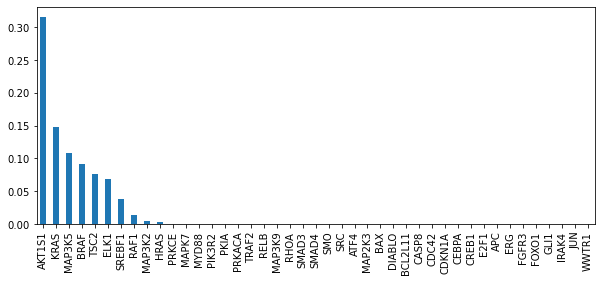

<IPython.core.display.Javascript object>

In [34]:
topk_accs.top1.sort_values(ascending=False).plot(kind="bar", figsize=[10, 4])

<AxesSubplot:>

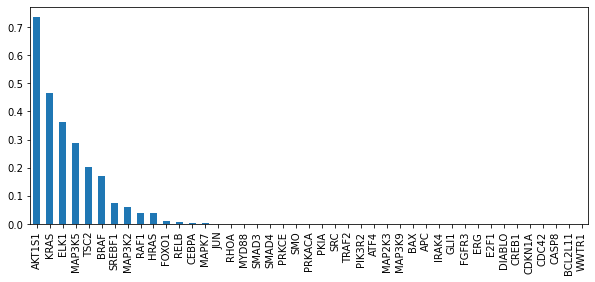

<IPython.core.display.Javascript object>

In [35]:
topk_accs.top3.sort_values(ascending=False).plot(kind="bar", figsize=[10, 4])

<AxesSubplot:>

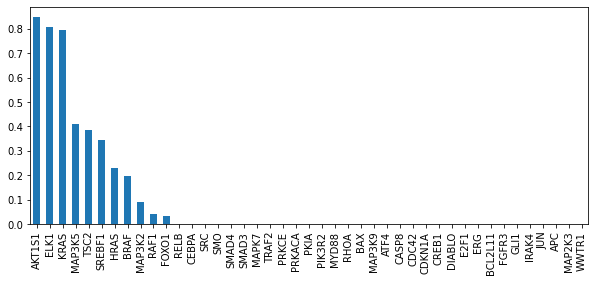

<IPython.core.display.Javascript object>

In [21]:
topk_accs.top5.sort_values(ascending=False).plot(kind="bar", figsize=[10, 4])

---

#### AKT1S1

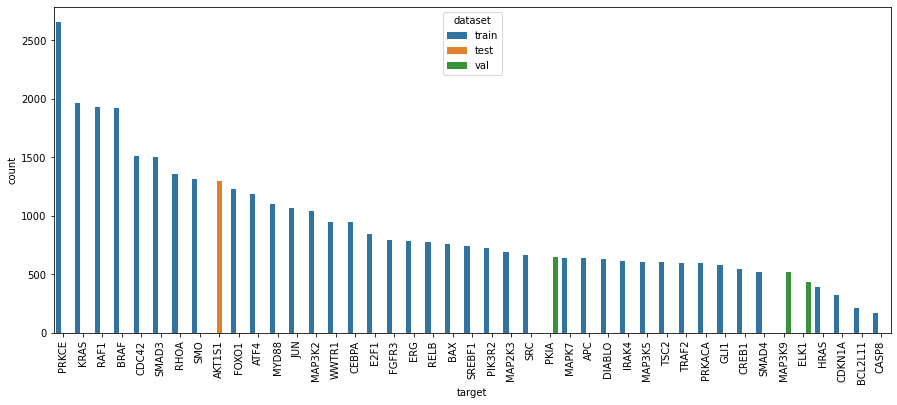

<IPython.core.display.Javascript object>

In [20]:
fig, ax, all_label_counts = plot_conditions_for_datadict(data_dicts[0])

In [16]:
fitted_model = train_model_topk_acc(
    model=model,
    data_dict=data_dicts[0],
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=1000,
    early_stopping=20,
    nn_clf=nn_clf,
    log_epochs=True,
)

train loss: 0.002619540559474704
train top-k accuracies: {1: 0.05569, 3: 0.11391, 5: 0.15503}
------------------------------------------------------------
val loss: 0.004935909630341345
val top-k accuracies: {1: 0.0, 3: 0.00279, 5: 0.00627}
------------------------------------------------------------
test loss: 0.0006680819450268223
test top-k accuracies: {1: 0.40818, 3: 0.67901, 5: 0.77623}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.002026867866932913
train top-k accuracies: {1: 0.11551, 3: 0.19493, 5: 0.24302}
------------------------------------------------------------
val loss: 0.0047753696967539365
val top-k accuracies: {1: 0.00418, 3: 0.01394, 5: 0.02091}
------------------------------------------------------------
test loss: 0.0009197452979415287
test top-k accuracies: {1: 0.21836, 3: 0.41435, 5: 0.54244}
------------------------------------------------------------
----------------------

train loss: 0.0004228039963253733
train top-k accuracies: {1: 0.70848, 3: 0.8453, 5: 0.8892}
------------------------------------------------------------
val loss: 0.004823481292181522
val top-k accuracies: {1: 0.00488, 3: 0.0223, 5: 0.03415}
------------------------------------------------------------
test loss: 0.0013227506948887933
test top-k accuracies: {1: 0.12269, 3: 0.29475, 5: 0.38889}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.00040013893657853594
train top-k accuracies: {1: 0.72914, 3: 0.86064, 5: 0.90325}
------------------------------------------------------------
val loss: 0.005321190429799492
val top-k accuracies: {1: 0.00139, 3: 0.01603, 5: 0.02718}
------------------------------------------------------------
test loss: 0.0012088848844193567
test top-k accuracies: {1: 0.12886, 3: 0.29938, 5: 0.41435}
------------------------------------------------------------
-------------------

<IPython.core.display.Javascript object>

(1540, 128)


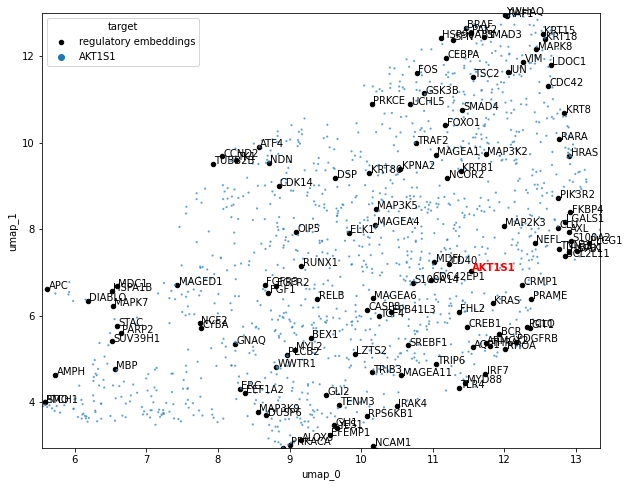

<IPython.core.display.Javascript object>

In [20]:
fig, ax = plot_translation(
    fitted_model,
    data_dicts[0]["test"].dataset,
    node_embs,
    figsize=[10, 8],
    crop=True,
    highlight_target="AKT1S1",
)
plt.show()

---

#### APC

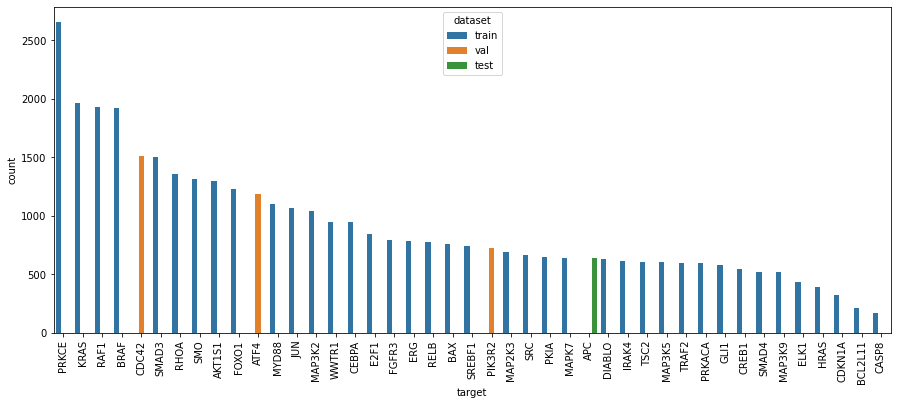

<IPython.core.display.Javascript object>

In [18]:
fig, ax, all_label_counts = plot_conditions_for_datadict(data_dicts[1])

In [21]:
fitted_model = train_model_topk_acc(
    model=model,
    data_dict=data_dicts[1],
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=1000,
    early_stopping=20,
    nn_clf=nn_clf,
    log_epochs=True,
)

train loss: 0.002714145158705243
train top-k accuracies: {1: 0.06273, 3: 0.12196, 5: 0.16559}
------------------------------------------------------------
val loss: 0.0019720774985957507
val top-k accuracies: {1: 0.00467, 3: 0.02335, 5: 0.03503}
------------------------------------------------------------
test loss: 0.006603786178675935
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.002076610605844761
train top-k accuracies: {1: 0.11682, 3: 0.20107, 5: 0.25179}
------------------------------------------------------------
val loss: 0.0020517787538763513
val top-k accuracies: {1: 0.00817, 3: 0.05108, 5: 0.07239}
------------------------------------------------------------
test loss: 0.007098908158928577
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
-------------------------------------------

val loss: 0.002439135001478657
val top-k accuracies: {1: 0.00409, 3: 0.02481, 5: 0.04407}
------------------------------------------------------------
test loss: 0.007619546058922538
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.00043398027576714777
train top-k accuracies: {1: 0.70862, 3: 0.84347, 5: 0.88807}
------------------------------------------------------------
val loss: 0.002449166991868069
val top-k accuracies: {1: 0.00234, 3: 0.02102, 5: 0.03765}
------------------------------------------------------------
test loss: 0.007195514805901509
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.000428510429723098
train top-k accuracies: {1: 0.71385, 3: 0.85108, 5: 0.89222}
-------------------------------------------

<IPython.core.display.Javascript object>

(881, 128)


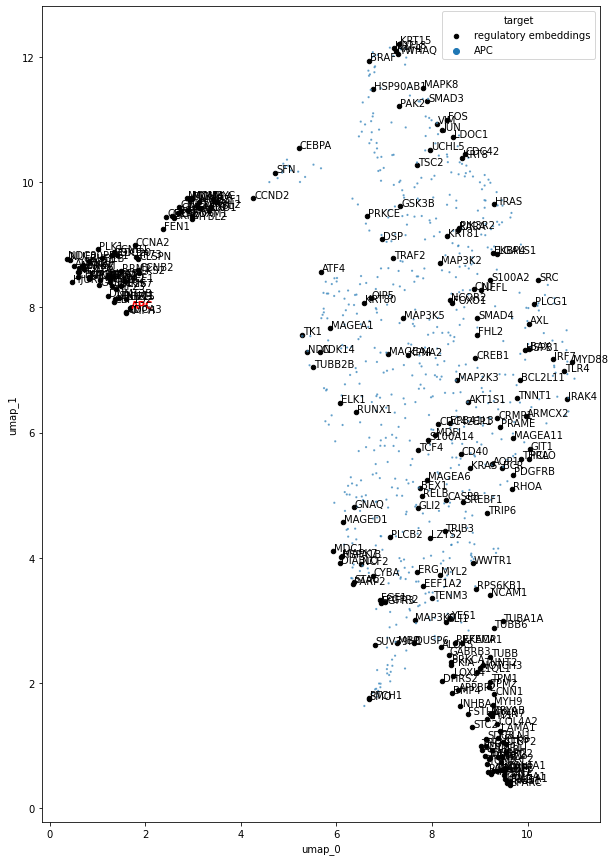

<IPython.core.display.Javascript object>

In [22]:
fig, ax = plot_translation(
    fitted_model,
    data_dicts[1]["test"].dataset,
    node_embs,
    figsize=[10, 15],
    crop=False,
    highlight_target="APC",
)
plt.show()

---

#### ATF4

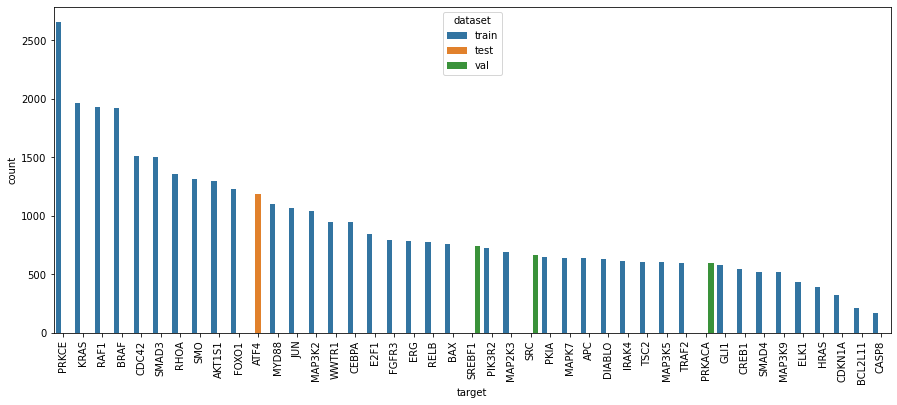

<IPython.core.display.Javascript object>

In [23]:
fig, ax, all_label_counts = plot_conditions_for_datadict(data_dicts[2])

In [24]:
fitted_model = train_model_topk_acc(
    model=model,
    data_dict=data_dicts[2],
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=1000,
    early_stopping=20,
    nn_clf=nn_clf,
    log_epochs=True,
)

train loss: 0.0026721439848681815
train top-k accuracies: {1: 0.06666, 3: 0.13434, 5: 0.17724}
------------------------------------------------------------
val loss: 0.003699199602007866
val top-k accuracies: {1: 0.007, 3: 0.0195, 5: 0.039}
------------------------------------------------------------
test loss: 0.002317889861149501
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.00253}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.002031059400884984
train top-k accuracies: {1: 0.12511, 3: 0.21333, 5: 0.26361}
------------------------------------------------------------
val loss: 0.00381945110950619
val top-k accuracies: {1: 0.0125, 3: 0.035, 5: 0.0565}
------------------------------------------------------------
test loss: 0.0025078526033945224
test top-k accuracies: {1: 0.00338, 3: 0.00591, 5: 0.00844}
------------------------------------------------------------
-------------------------------------

train loss: 0.0005163758191488275
train top-k accuracies: {1: 0.63471, 3: 0.79379, 5: 0.84719}
------------------------------------------------------------
val loss: 0.0042885928694158795
val top-k accuracies: {1: 0.0075, 3: 0.022, 5: 0.0415}
------------------------------------------------------------
test loss: 0.002851542018801917
test top-k accuracies: {1: 0.00253, 3: 0.01097, 5: 0.01519}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0004809118351680491
train top-k accuracies: {1: 0.66265, 3: 0.81512, 5: 0.86449}
------------------------------------------------------------
val loss: 0.004137507854029537
val top-k accuracies: {1: 0.007, 3: 0.0315, 5: 0.05}
------------------------------------------------------------
test loss: 0.0029518034126420943
test top-k accuracies: {1: 0.00084, 3: 0.00591, 5: 0.01181}
------------------------------------------------------------
---------------------------

<IPython.core.display.Javascript object>

(1429, 128)


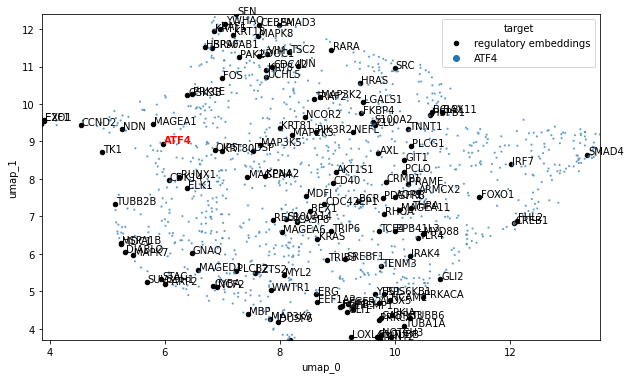

<IPython.core.display.Javascript object>

In [26]:
fig, ax = plot_translation(
    fitted_model,
    data_dicts[2]["test"].dataset,
    node_embs,
    figsize=[10, 6],
    crop=True,
    highlight_target="ATF4",
)
plt.show()

---

#### BAX

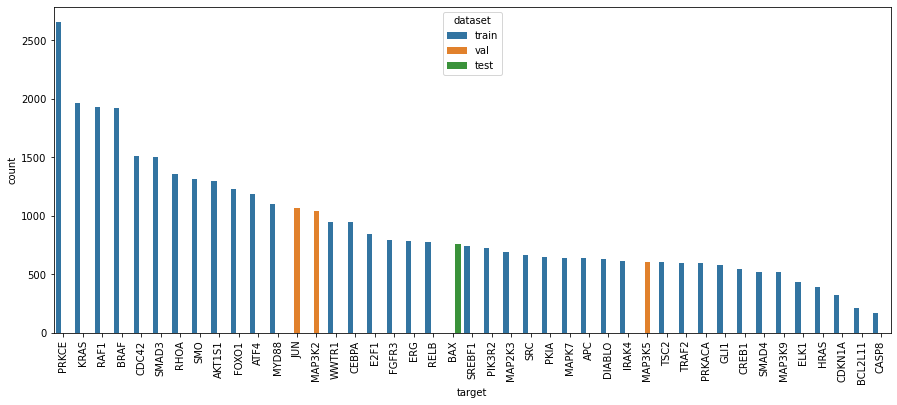

<IPython.core.display.Javascript object>

In [27]:
fig, ax, all_label_counts = plot_conditions_for_datadict(data_dicts[3])

In [28]:
fitted_model = train_model_topk_acc(
    model=model,
    data_dict=data_dicts[3],
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=1000,
    early_stopping=20,
    nn_clf=nn_clf,
    log_epochs=True,
)

train loss: 0.0028406269859081058
train top-k accuracies: {1: 0.04818, 3: 0.103, 5: 0.13876}
------------------------------------------------------------
val loss: 0.001408384260357358
val top-k accuracies: {1: 0.06787, 3: 0.13685, 5: 0.1671}
------------------------------------------------------------
test loss: 0.0037333177934624354
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.002163049066439271
train top-k accuracies: {1: 0.09302, 3: 0.17207, 5: 0.21742}
------------------------------------------------------------
val loss: 0.0015015408398395618
val top-k accuracies: {1: 0.04758, 3: 0.11472, 5: 0.15271}
------------------------------------------------------------
test loss: 0.003967589225698665
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
---------------------------------------------

train loss: 0.0005053310377515606
train top-k accuracies: {1: 0.65889, 3: 0.81395, 5: 0.86191}
------------------------------------------------------------
val loss: 0.0019475820735241217
val top-k accuracies: {1: 0.0166, 3: 0.06197, 5: 0.09738}
------------------------------------------------------------
test loss: 0.0041430358686496685
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.00048685921089817747
train top-k accuracies: {1: 0.67435, 3: 0.82773, 5: 0.87319}
------------------------------------------------------------
val loss: 0.0020260455802925364
val top-k accuracies: {1: 0.01623, 3: 0.05459, 5: 0.08078}
------------------------------------------------------------
test loss: 0.00426684017968917
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
-----------------------------------------

<IPython.core.display.Javascript object>

(1002, 128)


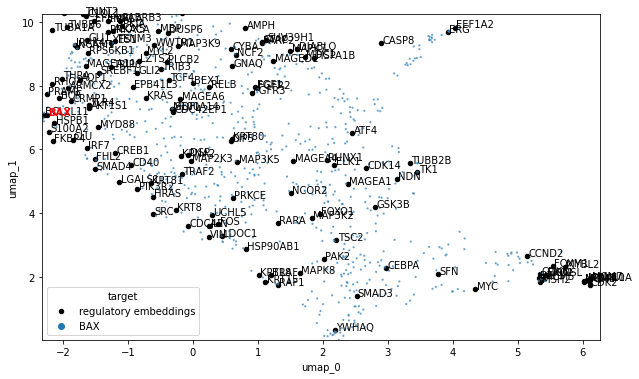

<IPython.core.display.Javascript object>

In [30]:
fig, ax = plot_translation(
    fitted_model,
    data_dicts[3]["test"].dataset,
    node_embs,
    figsize=[10, 6],
    crop=True,
    highlight_target="BAX",
)
plt.show()

---

#### BCL2L11

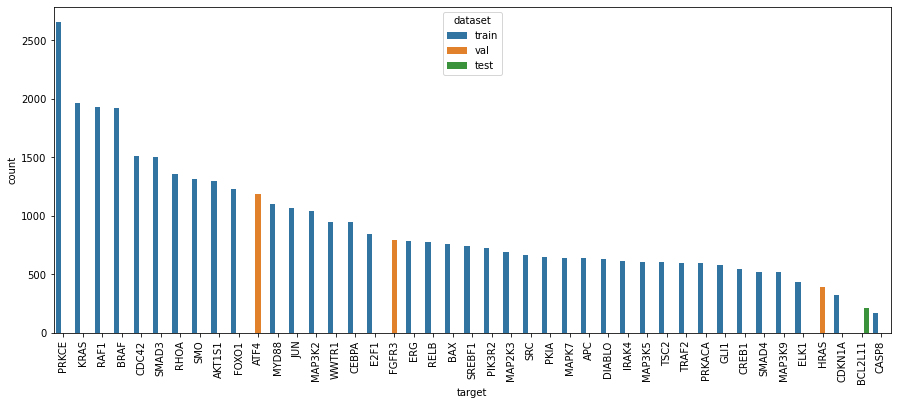

<IPython.core.display.Javascript object>

In [31]:
fig, ax, all_label_counts = plot_conditions_for_datadict(data_dicts[4])

In [32]:
fitted_model = train_model_topk_acc(
    model=model,
    data_dict=data_dicts[4],
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=1000,
    early_stopping=20,
    nn_clf=nn_clf,
    log_epochs=True,
)

train loss: 0.002760946390087702
train top-k accuracies: {1: 0.05338, 3: 0.11018, 5: 0.15114}
------------------------------------------------------------
val loss: 0.002763191504980276
val top-k accuracies: {1: 0.00507, 3: 0.01224, 5: 0.01984}
------------------------------------------------------------
test loss: 0.002555335856714221
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0020631097039001864
train top-k accuracies: {1: 0.1101, 3: 0.19796, 5: 0.24703}
------------------------------------------------------------
val loss: 0.002887654548077288
val top-k accuracies: {1: 0.00253, 3: 0.00633, 5: 0.0152}
------------------------------------------------------------
test loss: 0.0030113612074231686
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
---------------------------------------------

train loss: 0.0004827712501525313
train top-k accuracies: {1: 0.65738, 3: 0.81855, 5: 0.87218}
------------------------------------------------------------
val loss: 0.003192633098724926
val top-k accuracies: {1: 0.01098, 3: 0.02364, 5: 0.03166}
------------------------------------------------------------
test loss: 0.003398999189524803
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0004645813390924056
train top-k accuracies: {1: 0.67277, 3: 0.8321, 5: 0.882}
------------------------------------------------------------
val loss: 0.0031609405864088305
val top-k accuracies: {1: 0.01266, 3: 0.02279, 5: 0.0287}
------------------------------------------------------------
test loss: 0.003507630523770701
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
----------------------------------------------

<IPython.core.display.Javascript object>

(459, 128)


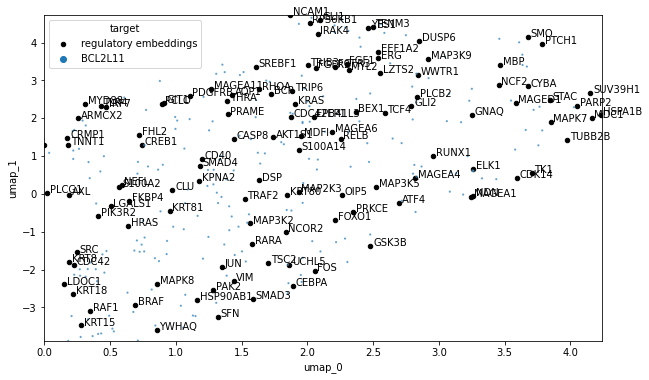

<IPython.core.display.Javascript object>

In [33]:
fig, ax = plot_translation(
    fitted_model,
    data_dicts[4]["test"].dataset,
    node_embs,
    figsize=[10, 6],
    crop=True,
    highlight_target="BCL2L11",
)
plt.show()

---

#### BRAF

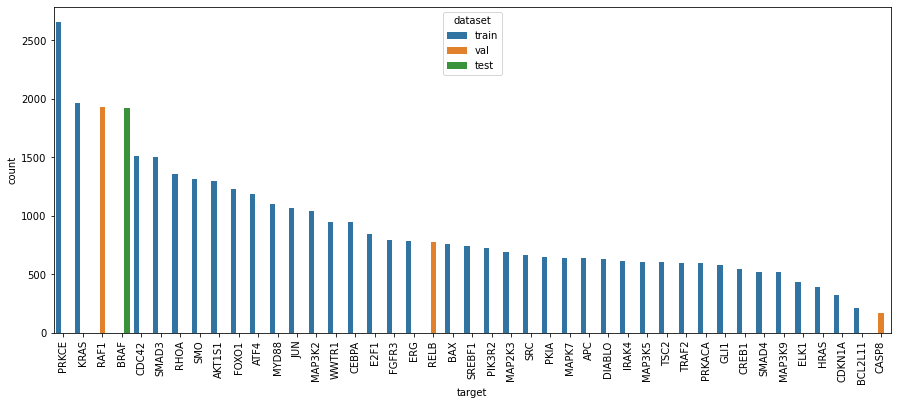

<IPython.core.display.Javascript object>

In [34]:
fig, ax, all_label_counts = plot_conditions_for_datadict(data_dicts[5])

In [35]:
fitted_model = train_model_topk_acc(
    model=model,
    data_dict=data_dicts[5],
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=1000,
    early_stopping=20,
    nn_clf=nn_clf,
    log_epochs=True,
)

train loss: 0.002744654019800126
train top-k accuracies: {1: 0.04915, 3: 0.10644, 5: 0.14691}
------------------------------------------------------------
val loss: 0.0042279814073779036
val top-k accuracies: {1: 0.0, 3: 0.0007, 5: 0.00695}
------------------------------------------------------------
test loss: 0.0031989197442798237
test top-k accuracies: {1: 0.0, 3: 0.00052, 5: 0.00208}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.002092564492692426
train top-k accuracies: {1: 0.09047, 3: 0.16989, 5: 0.21726}
------------------------------------------------------------
val loss: 0.003908447772934567
val top-k accuracies: {1: 0.00104, 3: 0.00765, 5: 0.0139}
------------------------------------------------------------
test loss: 0.0029331741686143592
test top-k accuracies: {1: 0.00261, 3: 0.01146, 5: 0.02606}
------------------------------------------------------------
----------------------------

train loss: 0.0005918890686557084
train top-k accuracies: {1: 0.60867, 3: 0.77792, 5: 0.83659}
------------------------------------------------------------
val loss: 0.004841534456780047
val top-k accuracies: {1: 0.00382, 3: 0.0139, 5: 0.0219}
------------------------------------------------------------
test loss: 0.0036828542638273057
test top-k accuracies: {1: 0.00886, 3: 0.0271, 5: 0.04273}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0005582487708655743
train top-k accuracies: {1: 0.63817, 3: 0.80082, 5: 0.85426}
------------------------------------------------------------
val loss: 0.004528352621308928
val top-k accuracies: {1: 0.00626, 3: 0.0212, 5: 0.03372}
------------------------------------------------------------
test loss: 0.003736168190175905
test top-k accuracies: {1: 0.00365, 3: 0.01563, 5: 0.0271}
------------------------------------------------------------
-----------------------

<IPython.core.display.Javascript object>

(2163, 128)


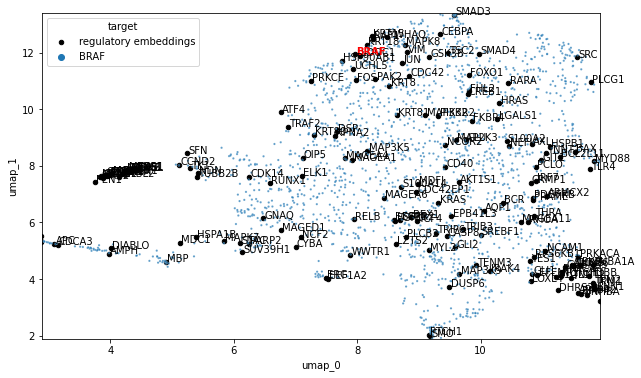

<IPython.core.display.Javascript object>

In [36]:
fig, ax = plot_translation(
    fitted_model,
    data_dicts[5]["test"].dataset,
    node_embs,
    figsize=[10, 6],
    crop=True,
    highlight_target="BRAF",
)
plt.show()

----

#### CASP8

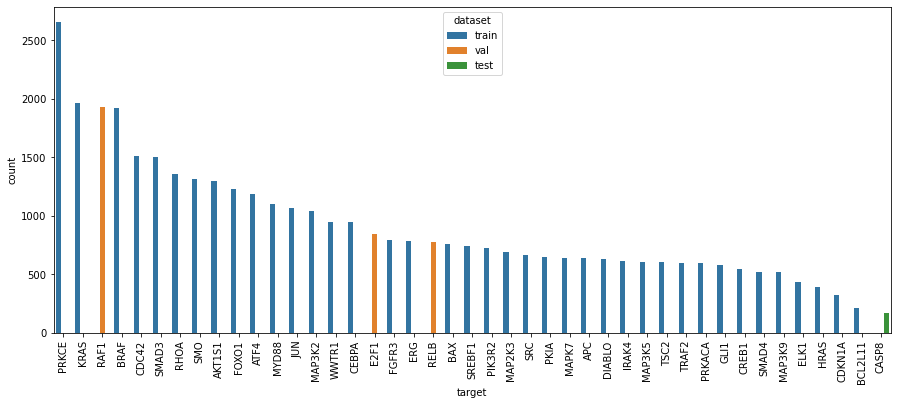

<IPython.core.display.Javascript object>

In [37]:
fig, ax, all_label_counts = plot_conditions_for_datadict(data_dicts[6])

In [38]:
fitted_model = train_model_topk_acc(
    model=model,
    data_dict=data_dicts[6],
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=50,
    early_stopping=20,
    nn_clf=nn_clf,
    log_epochs=True,
)

train loss: 0.0026860680368552417
train top-k accuracies: {1: 0.05097, 3: 0.11026, 5: 0.15057}
------------------------------------------------------------
val loss: 0.004748741581171818
val top-k accuracies: {1: 0.00169, 3: 0.00535, 5: 0.00873}
------------------------------------------------------------
test loss: 0.0020113793196298224
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.002028833054198018
train top-k accuracies: {1: 0.09811, 3: 0.18455, 5: 0.23342}
------------------------------------------------------------
val loss: 0.0046042351949926435
val top-k accuracies: {1: 0.00422, 3: 0.0152, 5: 0.0228}
------------------------------------------------------------
test loss: 0.0021389666876663067
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
-------------------------------------------

test loss: 0.0024680668659704296
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0005055660209996386
train top-k accuracies: {1: 0.65355, 3: 0.81904, 5: 0.86981}
------------------------------------------------------------
val loss: 0.005021394828233767
val top-k accuracies: {1: 0.00873, 3: 0.02843, 5: 0.03913}
------------------------------------------------------------
test loss: 0.0026536984845712693
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0004731426952524557
train top-k accuracies: {1: 0.6734, 3: 0.83776, 5: 0.88519}
------------------------------------------------------------
val loss: 0.005012407343045951
val top-k accuracies: {1: 0.01126, 3: 0.02984, 5: 0.04082}
------------------------------------------

<IPython.core.display.Javascript object>

(415, 128)


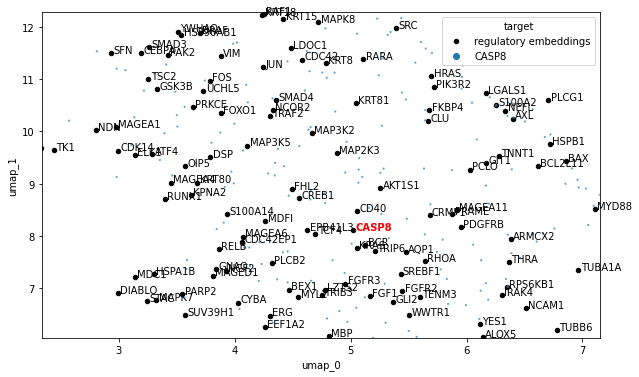

<IPython.core.display.Javascript object>

In [39]:
fig, ax = plot_translation(
    fitted_model,
    data_dicts[6]["test"].dataset,
    node_embs,
    figsize=[10, 6],
    crop=True,
    highlight_target="CASP8",
)
plt.show()

---

#### CDC42

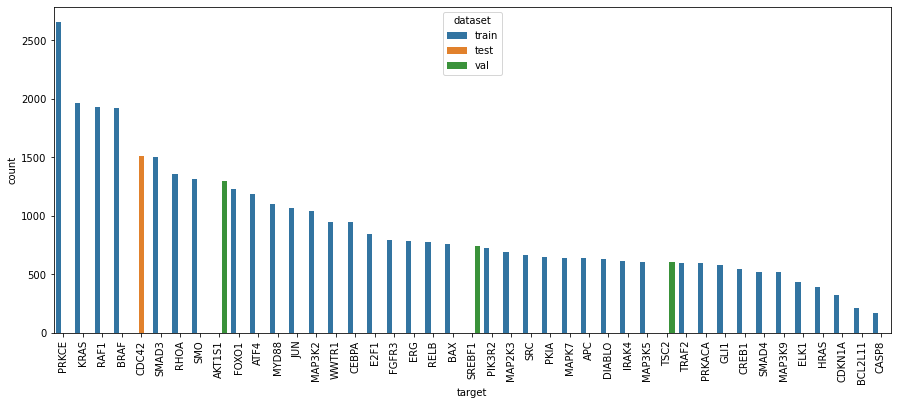

<IPython.core.display.Javascript object>

In [41]:
fig, ax, all_label_counts = plot_conditions_for_datadict(data_dicts[7])

In [42]:
fitted_model = train_model_topk_acc(
    model=model,
    data_dict=data_dicts[7],
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=50,
    early_stopping=20,
    nn_clf=nn_clf,
    log_epochs=True,
)

train loss: 0.0029456173377680117
train top-k accuracies: {1: 0.02694, 3: 0.07383, 5: 0.10966}
------------------------------------------------------------
val loss: 0.0010547024714797537
val top-k accuracies: {1: 0.22281, 3: 0.39712, 5: 0.46684}
------------------------------------------------------------
test loss: 0.001722750626011658
test top-k accuracies: {1: 0.05159, 3: 0.11839, 5: 0.15807}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0022167300319501436
train top-k accuracies: {1: 0.07919, 3: 0.15357, 5: 0.19986}
------------------------------------------------------------
val loss: 0.0012253867551386525
val top-k accuracies: {1: 0.11482, 3: 0.23456, 5: 0.32702}
------------------------------------------------------------
test loss: 0.0021403101691729806
test top-k accuracies: {1: 0.00331, 3: 0.03373, 5: 0.07341}
------------------------------------------------------------
----------------

train loss: 0.0005688458915538798
train top-k accuracies: {1: 0.61906, 3: 0.78277, 5: 0.83686}
------------------------------------------------------------
val loss: 0.0017902741778000354
val top-k accuracies: {1: 0.07048, 3: 0.16105, 5: 0.22319}
------------------------------------------------------------
test loss: 0.0022814535737904922
test top-k accuracies: {1: 0.0086, 3: 0.05423, 5: 0.09325}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0005353394224760612
train top-k accuracies: {1: 0.6423, 3: 0.8014, 5: 0.85291}
------------------------------------------------------------
val loss: 0.0017785710111816596
val top-k accuracies: {1: 0.06593, 3: 0.14854, 5: 0.20538}
------------------------------------------------------------
test loss: 0.0022420786153623667
test top-k accuracies: {1: 0.0119, 3: 0.05357, 5: 0.10582}
------------------------------------------------------------
-------------------

<IPython.core.display.Javascript object>

In [ ]:
fig, ax = plot_translation(
    fitted_model,
    data_dicts[7]["test"].dataset,
    node_embs,
    figsize=[10, 6],
    crop=True,
    highlight_target="CDC42",
)
plt.show()

---

#### CDKN1A

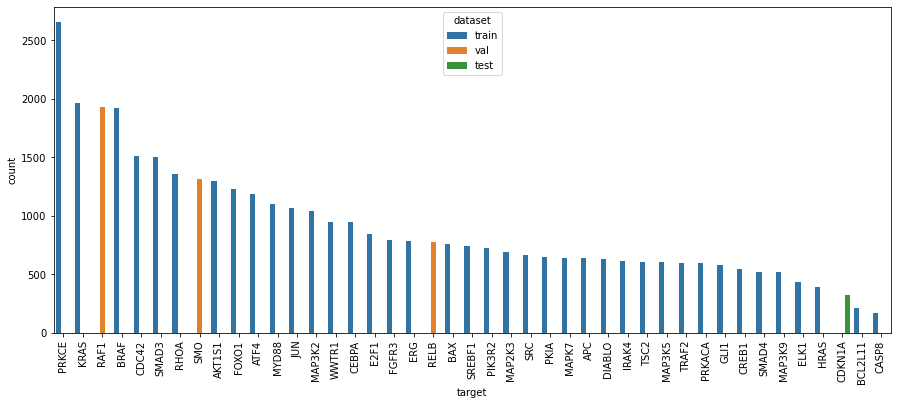

<IPython.core.display.Javascript object>

In [43]:
fig, ax, all_label_counts = plot_conditions_for_datadict(data_dicts[8])

In [44]:
fitted_model = train_model_topk_acc(
    model=model,
    data_dict=data_dicts[8],
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=50,
    early_stopping=20,
    nn_clf=nn_clf,
    log_epochs=True,
)

train loss: 0.002397817505285604
train top-k accuracies: {1: 0.04782, 3: 0.10374, 5: 0.14779}
------------------------------------------------------------
val loss: 0.005708566993151022
val top-k accuracies: {1: 0.00199, 3: 0.00398, 5: 0.00944}
------------------------------------------------------------
test loss: 0.02589857318427092
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0017971540540289257
train top-k accuracies: {1: 0.08616, 3: 0.1686, 5: 0.22342}
------------------------------------------------------------
val loss: 0.00582654956473697
val top-k accuracies: {1: 0.00696, 3: 0.01615, 5: 0.02012}
------------------------------------------------------------
test loss: 0.025610751023998967
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
-----------------------------------------------

val loss: 0.006268673482703866
val top-k accuracies: {1: 0.01068, 3: 0.02907, 5: 0.04099}
------------------------------------------------------------
test loss: 0.026312135573890474
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0005455514097362491
train top-k accuracies: {1: 0.63015, 3: 0.80367, 5: 0.85853}
------------------------------------------------------------
val loss: 0.0061902525021422725
val top-k accuracies: {1: 0.01168, 3: 0.02584, 5: 0.03503}
------------------------------------------------------------
test loss: 0.026857090952955645
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0005085349777566252
train top-k accuracies: {1: 0.66479, 3: 0.82791, 5: 0.87911}
------------------------------------------

<IPython.core.display.Javascript object>

(568, 128)


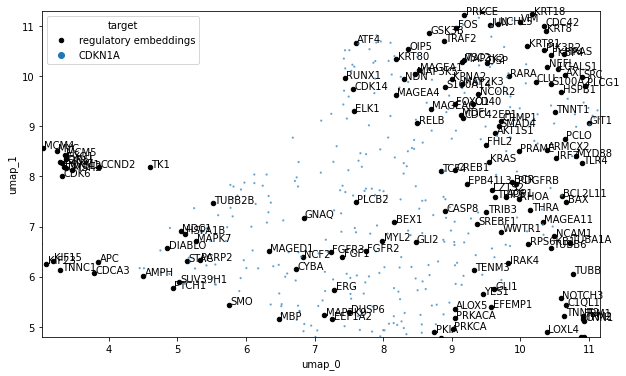

<IPython.core.display.Javascript object>

In [46]:
fig, ax = plot_translation(
    fitted_model,
    data_dicts[8]["test"].dataset,
    node_embs,
    figsize=[10, 6],
    crop=True,
    highlight_target="CDKN1A",
)
plt.show()

---

#### CEBPA



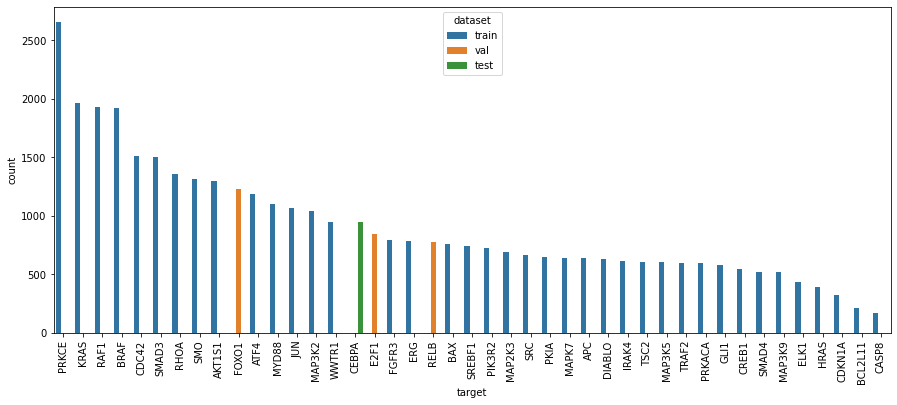

<IPython.core.display.Javascript object>

In [49]:
fig, ax, all_label_counts = plot_conditions_for_datadict(data_dicts[9])

In [50]:
fitted_model = train_model_topk_acc(
    model=model,
    data_dict=data_dicts[9],
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=50,
    early_stopping=20,
    nn_clf=nn_clf,
    log_epochs=True,
)

train loss: 0.0028612296612578973
train top-k accuracies: {1: 0.05693, 3: 0.10593, 5: 0.13905}
------------------------------------------------------------
val loss: 0.0030808470063498684
val top-k accuracies: {1: 0.0, 3: 0.01926, 5: 0.09352}
------------------------------------------------------------
test loss: 0.002770845768206144
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.00634}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0021400981548251336
train top-k accuracies: {1: 0.09969, 3: 0.16706, 5: 0.21065}
------------------------------------------------------------
val loss: 0.0032855548187617324
val top-k accuracies: {1: 0.00035, 3: 0.03363, 5: 0.08722}
------------------------------------------------------------
test loss: 0.002602985006813137
test top-k accuracies: {1: 0.00211, 3: 0.00528, 5: 0.01056}
------------------------------------------------------------
-----------------------------

train loss: 0.0005484687191627636
train top-k accuracies: {1: 0.60819, 3: 0.7746, 5: 0.83314}
------------------------------------------------------------
val loss: 0.00393172465427901
val top-k accuracies: {1: 0.01051, 3: 0.04588, 5: 0.08616}
------------------------------------------------------------
test loss: 0.003227669955157491
test top-k accuracies: {1: 0.00106, 3: 0.00106, 5: 0.00634}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0005234554663201195
train top-k accuracies: {1: 0.62953, 3: 0.79273, 5: 0.84551}
------------------------------------------------------------
val loss: 0.0038775189409453272
val top-k accuracies: {1: 0.0035, 3: 0.03327, 5: 0.0627}
------------------------------------------------------------
test loss: 0.002958964878533905
test top-k accuracies: {1: 0.0, 3: 0.00528, 5: 0.01373}
------------------------------------------------------------
--------------------------

<IPython.core.display.Javascript object>

(1191, 128)


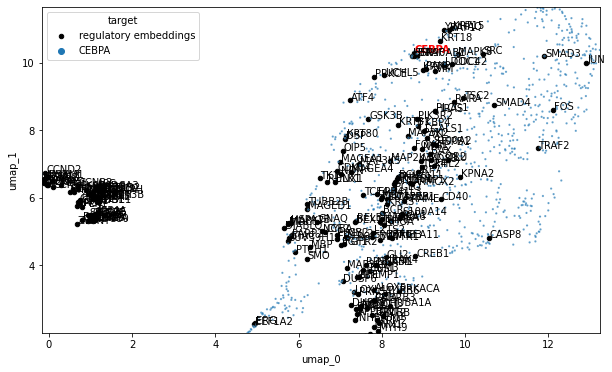

<IPython.core.display.Javascript object>

In [51]:
fig, ax = plot_translation(
    fitted_model,
    data_dicts[9]["test"].dataset,
    node_embs,
    figsize=[10, 6],
    crop=True,
    highlight_target="CEBPA",
)
plt.show()

---

#### CREB1

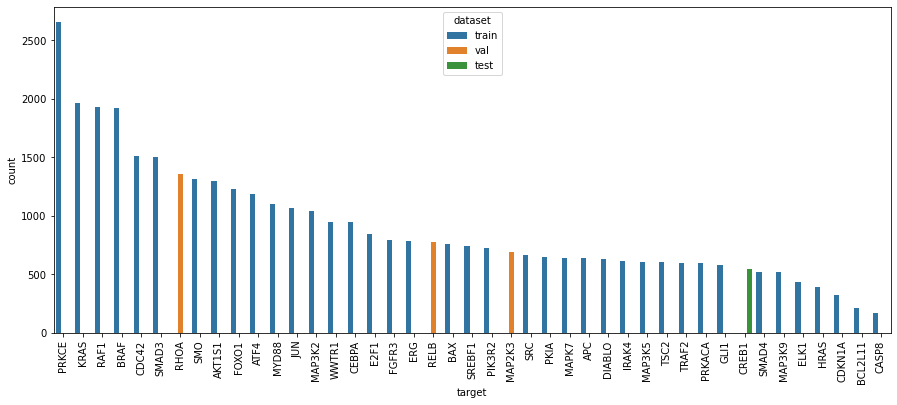

<IPython.core.display.Javascript object>

In [47]:
fig, ax, all_label_counts = plot_conditions_for_datadict(data_dicts[10])

In [48]:
fitted_model = train_model_topk_acc(
    model=model,
    data_dict=data_dicts[10],
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=50,
    early_stopping=20,
    nn_clf=nn_clf,
    log_epochs=True,
)

train loss: 0.00294436960520688
train top-k accuracies: {1: 0.04951, 3: 0.11584, 5: 0.15766}
------------------------------------------------------------
val loss: 0.0016285798841528067
val top-k accuracies: {1: 0.00035, 3: 0.00212, 5: 0.00956}
------------------------------------------------------------
test loss: 0.0020315546995274478
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.002175820255360697
train top-k accuracies: {1: 0.10482, 3: 0.19276, 5: 0.24336}
------------------------------------------------------------
val loss: 0.001921072559069747
val top-k accuracies: {1: 0.00071, 3: 0.00673, 5: 0.01381}
------------------------------------------------------------
test loss: 0.0021154970270086883
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
-------------------------------------------

train loss: 0.0006077667935174247
train top-k accuracies: {1: 0.62034, 3: 0.79132, 5: 0.84758}
------------------------------------------------------------
val loss: 0.002435155296315658
val top-k accuracies: {1: 0.00354, 3: 0.01629, 5: 0.03222}
------------------------------------------------------------
test loss: 0.0025588145697891932
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0005729132947250075
train top-k accuracies: {1: 0.64644, 3: 0.81341, 5: 0.86412}
------------------------------------------------------------
val loss: 0.0024759019926195655
val top-k accuracies: {1: 0.00248, 3: 0.00885, 5: 0.02373}
------------------------------------------------------------
test loss: 0.0026639086209687885
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
----------------------------------------

<IPython.core.display.Javascript object>

(790, 128)


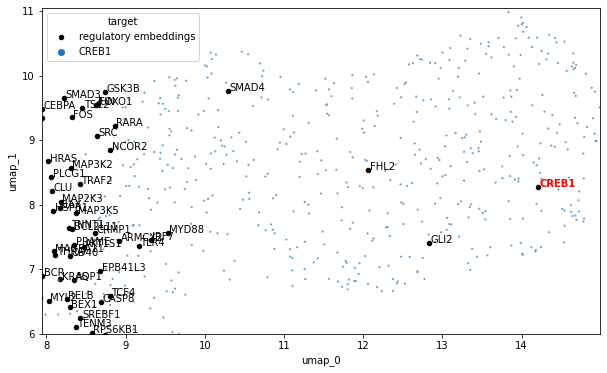

<IPython.core.display.Javascript object>

In [52]:
fig, ax = plot_translation(
    fitted_model,
    data_dicts[10]["test"].dataset,
    node_embs,
    figsize=[10, 6],
    crop=True,
    highlight_target="CREB1",
)
plt.show()

---

#### CSNK1E

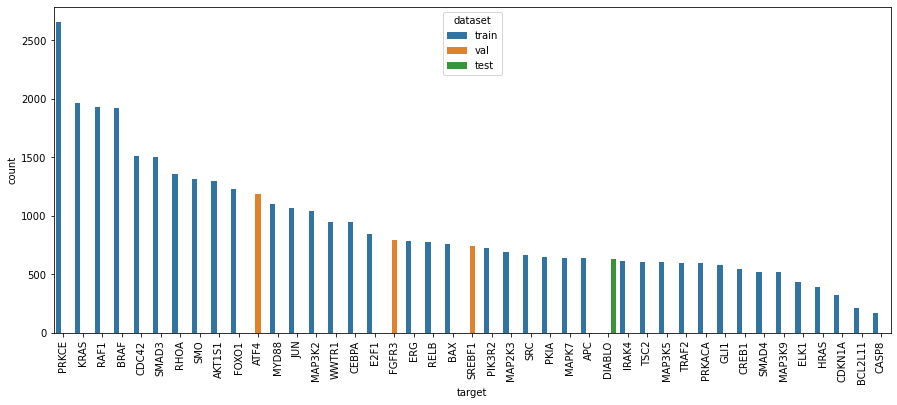

<IPython.core.display.Javascript object>

In [53]:
fig, ax, all_label_counts = plot_conditions_for_datadict(data_dicts[11])

In [54]:
fitted_model = train_model_topk_acc(
    model=model,
    data_dict=data_dicts[11],
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=50,
    early_stopping=20,
    nn_clf=nn_clf,
    log_epochs=True,
)

train loss: 0.0027969493016754047
train top-k accuracies: {1: 0.05287, 3: 0.10997, 5: 0.15537}
------------------------------------------------------------
val loss: 0.0025276897262016904
val top-k accuracies: {1: 0.00516, 3: 0.0221, 5: 0.03389}
------------------------------------------------------------
test loss: 0.0038360337779488204
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.002094163647473159
train top-k accuracies: {1: 0.10017, 3: 0.19059, 5: 0.24038}
------------------------------------------------------------
val loss: 0.002785855644677541
val top-k accuracies: {1: 0.01768, 3: 0.03352, 5: 0.04715}
------------------------------------------------------------
test loss: 0.004426372231646154
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
-------------------------------------------

train loss: 0.0005460218736812113
train top-k accuracies: {1: 0.61765, 3: 0.77963, 5: 0.83287}
------------------------------------------------------------
val loss: 0.0030562928536028685
val top-k accuracies: {1: 0.01363, 3: 0.03241, 5: 0.05083}
------------------------------------------------------------
test loss: 0.004625213991428884
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.00629}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0005117024581324342
train top-k accuracies: {1: 0.63945, 3: 0.7988, 5: 0.85007}
------------------------------------------------------------
val loss: 0.003113024681549293
val top-k accuracies: {1: 0.00884, 3: 0.02431, 5: 0.03867}
------------------------------------------------------------
test loss: 0.004732165845849042
test top-k accuracies: {1: 0.0, 3: 0.00314, 5: 0.00786}
------------------------------------------------------------
-------------------------------

<IPython.core.display.Javascript object>

(880, 128)


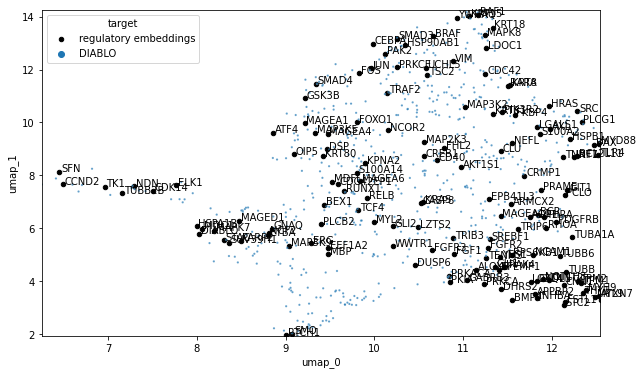

<IPython.core.display.Javascript object>

In [55]:
fig, ax = plot_translation(
    fitted_model,
    data_dicts[11]["test"].dataset,
    node_embs,
    figsize=[10, 6],
    crop=True,
    highlight_target="CSNK1E",
)
plt.show()

---

#### CXXC4

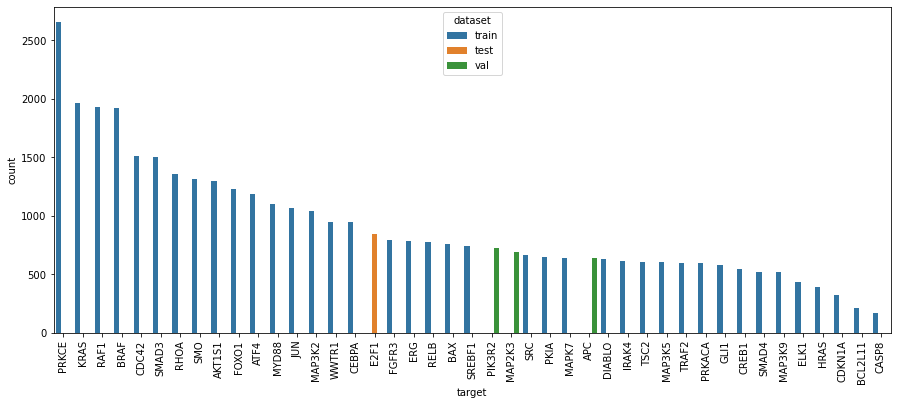

<IPython.core.display.Javascript object>

In [56]:
fig, ax, all_label_counts = plot_conditions_for_datadict(data_dicts[12])

In [57]:
fitted_model = train_model_topk_acc(
    model=model,
    data_dict=data_dicts[12],
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=50,
    early_stopping=20,
    nn_clf=nn_clf,
    log_epochs=True,
)

train loss: 0.0027098148591714576
train top-k accuracies: {1: 0.05119, 3: 0.10767, 5: 0.14924}
------------------------------------------------------------
val loss: 0.003002468991750422
val top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
test loss: 0.007053754426732695
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0020411178064019585
train top-k accuracies: {1: 0.09818, 3: 0.18242, 5: 0.23223}
------------------------------------------------------------
val loss: 0.0032295653709881115
val top-k accuracies: {1: 0.0, 3: 0.00194, 5: 0.01069}
------------------------------------------------------------
test loss: 0.00873655969845065
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
-----------------------------------------------------------

train loss: 0.000518955779717246
train top-k accuracies: {1: 0.64267, 3: 0.80682, 5: 0.85804}
------------------------------------------------------------
val loss: 0.0036735490165411906
val top-k accuracies: {1: 0.00097, 3: 0.01506, 5: 0.03256}
------------------------------------------------------------
test loss: 0.008878537255557293
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
------------------------------------------------------------
train loss: 0.0005011258595300218
train top-k accuracies: {1: 0.65711, 3: 0.81814, 5: 0.86778}
------------------------------------------------------------
val loss: 0.0035837642417223246
val top-k accuracies: {1: 0.00049, 3: 0.01118, 5: 0.02138}
------------------------------------------------------------
test loss: 0.00883648045202519
test top-k accuracies: {1: 0.0, 3: 0.0, 5: 0.0}
------------------------------------------------------------
-------------------------------------------

<IPython.core.display.Javascript object>

(1090, 128)


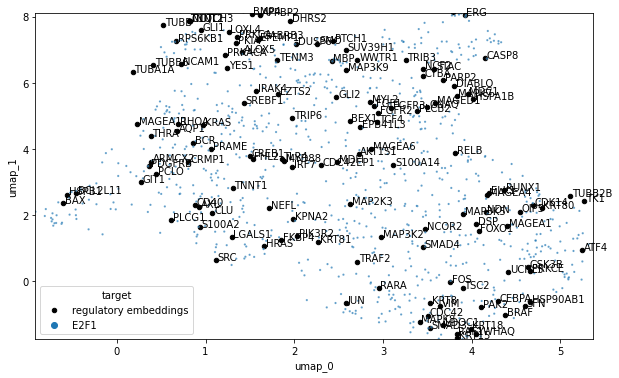

<IPython.core.display.Javascript object>

In [59]:
fig, ax = plot_translation(
    fitted_model,
    data_dicts[12]["test"].dataset,
    node_embs,
    figsize=[10, 6],
    crop=True,
    highlight_target="CXXC4",
)
plt.show()

---

###